In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('Reviews.csv')
df.shape

(568454, 10)

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.head().T

,0,1,2,3,4
Id,1,2,3,4,5
ProductId,B001E4KFG0,B00813GRG4,B000LQOCH0,B000UA0QIQ,B006K2ZZ7K
UserId,A3SGXH7AUHU8GW,A1D87F6ZCVE5NK,ABXLMWJIXXAIN,A395BORC6FGVXV,A1UQRSCLF8GW1T
ProfileName,delmartian,dll pa,"Natalia Corres ""Natalia Corres""",Karl,"Michael D. Bigham ""M. Wassir"""
HelpfulnessNumerator,1,0,1,3,0
HelpfulnessDenominator,1,0,1,3,0
Score,5,1,4,2,5
Time,1303862400,1346976000,1219017600,1307923200,1350777600
Summary,Good Quality Dog Food,Not as Advertised,"""Delight"" says it all",Cough Medicine,Great taffy
Text,I have bought several of the Vitality canned d...,Product arrived labeled as Jumbo Salted Peanut...,This is a confection that has been around a fe...,If you are looking for the secret ingredient i...,Great taffy at a great price. There was a wid...


In [5]:
df = df[['Text', 'Score']].dropna()

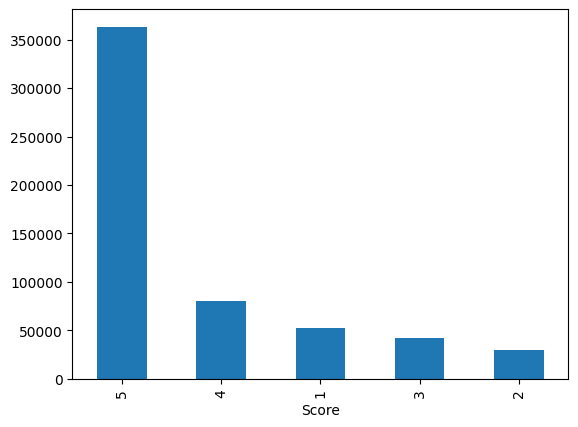

In [6]:
ax = df.Score.value_counts().plot(kind = 'bar')
fig = ax.get_figure()
fig.savefig("Score.png")

We have five-star rating system. It looks like we have more reviews with ratings 5, this can lead to unbalanced classes. We will treat rating 4 and 5 as positive and rest as negative reviews.

In [7]:
df.Score[df.Score <= 3] = 0
df.Score[df.Score >= 4] = 1

C:\Users\rohit\AppData\Local\Temp\ipykernel_3560\4224550207.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Score[df.Score <= 3] = 0
C:\Users\rohit\AppData\Local\Temp\ipykernel_3560\4224550207.py:1: SettingWithCopyWarning: 
A value is

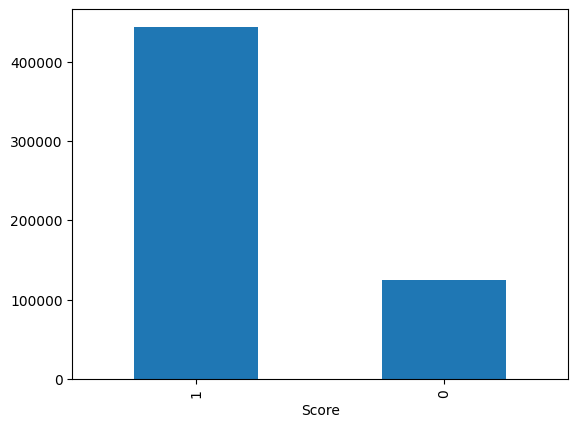

In [8]:
ax = df.Score.value_counts().plot(kind = 'bar')
fig = ax.get_figure()
fig.savefig('score_boolean.png')

In [9]:
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


Since we have huge data, since it might be difficult to train in kernel, I will reduce data size of 100K rows. To balance classes, i have selected equal samples from each class.

In [10]:
train_pos_df = df[df.Score == 1][:50000]
train_neg_df = df[df.Score == 0][:50000]

In [11]:
train_df = pd.concat([train_pos_df, train_neg_df])
train_df.shape

(100000, 2)

In [12]:
val_pos_df = df[df.Score==1][50000:60000]
val_neg_df = df[df.Score==0][50000:60000]
val_df = pd.concat([val_pos_df, val_neg_df])
val_df.shape

(20000, 2)

#### **Tokenization**

First step in any nlp pipeline is tokenizing text i.e breaking down paragraphs into sentenses and then sentenses into words, punctuations and so on.

we will load english language model to tokenize our english text.

Every language is different and have different rules. Spacy offers 8 different language models.

In [13]:
spacy_tok = spacy.load('en_core_web_sm')
sample_review = df.Text[54]
sample_review

"I roast at home with a stove-top popcorn popper (but I do it outside, of course). These beans (Coffee Bean Direct Green Mexican Altura) seem to be well-suited for this method. The first and second cracks are distinct, and I've roasted the beans from medium to slightly dark with great results every time. The aroma is strong and persistent. The taste is smooth, velvety, yet lively."

In [14]:
parsed_review = spacy_tok(sample_review)
parsed_review

I roast at home with a stove-top popcorn popper (but I do it outside, of course). These beans (Coffee Bean Direct Green Mexican Altura) seem to be well-suited for this method. The first and second cracks are distinct, and I've roasted the beans from medium to slightly dark with great results every time. The aroma is strong and persistent. The taste is smooth, velvety, yet lively.

There is not much difference between parsed review and original one. But we will see ahead what has actually happened. We can see how parsing has been done visually through explacy.

In [15]:
# import requests

# url = 'https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py'
# response = requests.get(url)

# with open('explacy.py', 'w', encoding='utf-8') as f:
#     f.write(response.text)


In [16]:
import explacy
explacy.print_parse_info(spacy_tok, 'The salad was surprisingly tasty')

Dep tree Token        Dep type Lemma        Part of Sp
──────── ──────────── ──────── ──────────── ──────────
   ┌─►   The          det      the          DET       
┌─►└──   salad        nsubj    salad        NOUN      
├─────   was          ROOT     be           AUX       
│  ┌─►   surprisingly advmod   surprisingly ADV       
└─►└──   tasty        acomp    tasty        ADJ       


In [17]:
explacy.print_parse_info(spacy_tok, df.Text[0])

Dep tree             Token       Dep type Lemma      Part of Sp
──────────────────── ─────────── ──────── ────────── ──────────
                ┌──► I           nsubj    I          PRON      
                │┌─► have        aux      have       AUX       
┌┬┬┬────────────┴┴── bought      ROOT     buy        VERB      
│││└─►┌───────────── several     dobj     several    ADJ       
│││   └─►┌────────── of          prep     of         ADP       
│││      │  ┌──────► the         det      the        DET       
│││      │  │    ┌─► Vitality    npadvmod Vitality   PROPN     
│││      │  │┌──►└── canned      amod     can        VERB      
│││      │  ││   ┌─► dog         compound dog        NOUN      
│││      │  ││┌─►└── food        compound food       NOUN      
│││      └─►└┴┴───── products    pobj     product    NOUN      
││└────────────────► and         cc       and        CCONJ     
││               ┌─► have        aux      have       AUX       
│└─────►┌────────┴── found       conj   

#### **Part-of-speech tagging**

After tokenization we can parse and tag variety of parts of speech to paragraph text. SpaCy uses statistical models in background to predict which tag will go for each word(s) based on the context.

#### **Lemmatization**

It is the process of extracting uninflected/base form of the word. Lemma can be like For eg.

Adjectives: best, better → good Adverbs: worse, worst → badly Nouns: ducks, children → duck, child Verbs: standing,stood → stand

In [18]:
tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text[:20]

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,I,I,PRON,PRP,nsubj,X,True,True,False
1,roast,roast,VERB,VBP,ROOT,xxxx,True,False,False
2,at,at,ADP,IN,prep,xx,True,True,False
3,home,home,NOUN,NN,pobj,xxxx,True,False,False
4,with,with,ADP,IN,prep,xxxx,True,True,False
5,a,a,DET,DT,det,x,True,True,False
6,stove,stove,NOUN,NN,nmod,xxxx,True,False,False
7,-,-,PUNCT,HYPH,punct,-,False,False,True
8,top,top,NOUN,NN,pobj,xxx,True,True,False
9,popcorn,popcorn,NOUN,NN,compound,xxxx,True,False,False


In [19]:
spacy.displacy.render(parsed_review, style = 'ent', jupyter = True)

In [20]:
spacy.explain('GPE')

'Countries, cities, states'

#### **Dependency parsing**

Syntactic Parsing or Dependency Parsing is process of identifyig sentenses and assigning a syntactic structure to it. As in Subject combined with object makes a sentence. Spacy provides parse tree which can be used to generate this structure.

#### **Sentense Boundry Detection**

Figuring out where sentense starts and ends is very imporatnt part of nlp.

In [21]:
sentence_spans = list(parsed_review)
sentence_spans

[I,
 roast,
 at,
 home,
 with,
 a,
 stove,
 -,
 top,
 popcorn,
 popper,
 (,
 but,
 I,
 do,
 it,
 outside,
 ,,
 of,
 course,
 ),
 .,
 These,
 beans,
 (,
 Coffee,
 Bean,
 Direct,
 Green,
 Mexican,
 Altura,
 ),
 seem,
 to,
 be,
 well,
 -,
 suited,
 for,
 this,
 method,
 .,
 The,
 first,
 and,
 second,
 cracks,
 are,
 distinct,
 ,,
 and,
 I,
 've,
 roasted,
 the,
 beans,
 from,
 medium,
 to,
 slightly,
 dark,
 with,
 great,
 results,
 every,
 time,
 .,
 The,
 aroma,
 is,
 strong,
 and,
 persistent,
 .,
 The,
 taste,
 is,
 smooth,
 ,,
 velvety,
 ,,
 yet,
 lively,
 .]

In [22]:
displacy.render(parsed_review, style = 'dep', jupyter = True, options = {'distance': 100})

In [23]:
options = {'compact': True, 'bg': 'black','distance': 100,
           'color': 'white', 'font': 'Trebuchet MS'}
displacy.render(parsed_review, jupyter=True, style='dep', options=options)

In [24]:
spacy.explain("ADJ"), spacy.explain("det"), spacy.explain("ADP"), spacy.explain("prep")

('adjective', 'determiner', 'adposition', 'prepositional modifier')

In [25]:
# Processing Noun Chunks

noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed_review.noun_chunks):
    noun_chunks_df.loc[i, 'text'] = chunk.text
    noun_chunks_df.loc[i, 'root'] = chunk.root
    noun_chunks_df.loc[i, 'root.text'] = chunk.root.text
    noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
    noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df[:20]

,text,root,root.text,root.dep_,root.head.text
0,I,I,I,nsubj,roast
1,home,home,home,pobj,at
2,top,top,top,pobj,stove
3,I,I,I,nsubj,do
4,it,it,it,dobj,do
5,course,course,course,pobj,of
6,These beans,beans,beans,nsubj,seem
7,Coffee Bean Direct Green Mexican Altura,Altura,Altura,appos,beans
8,this method,method,method,pobj,for
9,The first and second cracks,cracks,cracks,nsubj,are


In [26]:
# import scattertext as st
# nlp = spacy.load('en_core_web_sm', disable=["tagger", "ner"])


In [27]:
# import scattertext as st

# nlp = spacy.load('en',disable_pipes=["tagger","ner"])
# train_df['parsed'] = train_df.Text[49500:50500].apply(nlp)
# corpus = st.CorpusFromParsedDocuments(train_df[49500:50500],
#                              category_col='Score',
#                              parsed_col='parsed').build()

#### **Sence2vec**

The idea is get something better than word2vec model.

The idea behind sense2vec is super simple. If the problem is that duck as in waterfowl and duck as in crouch are different concepts, the straight-forward solution is to just have two entries, duckN and duckV. Trask et al (2015) published a nice set of experiments showing that the idea worked well.

It assight parts of speech tags like verb, noun , adjective to words, which will in turn be used to make sence of context.

In [28]:
# import sense2vec
# from sense2vec import Sense2VecComponent

# s2v = Sense2VecComponent('reddit_vectors-1.1.0/')
# spacy_tok.add_pipe(s2v)
# doc = spacy_tok(u"dessert.")
# freq = doc[0]._.s2v_freq
# vector = doc[0]._.s2v_vec
# most_similar = doc[0]._.s2v_most_similar(5)
# most_similar,freq

#### **SpaCy Text Categorizer**

We will train a multi-label convolutional neural network text classifier on our food reviews, using spaCy's new TextCategorizer component.

SpaCy provides classification model with multiple, non-mutually exclusive labels. You can change the model architecture rather easily, but by default, the TextCategorizer class uses a convolutional neural network to assign position-sensitive vectors to each word in the document. The TextCategorizer uses its own CNN model, to avoid sharing weights with the other pipeline components. The document tensor is then summarized by concatenating max and mean pooling, and a multilayer perceptron is used to predict an output vector of length nr_class, before a logistic activation is applied elementwise. The value of each output neuron is the probability that some class is present

In [29]:
# Preparing the data
train_df['tuples'] = train_df.apply(
    lambda row: (row['Text'], row['Score']), axis = 1)
train = train_df['tuples'].tolist()
train[:1]

[('I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
  1)]

In [30]:
train[-2:]

[("I ordered this product specifically to try out the three different types of products. However, when I received the product, I opened it up only to find three of the Barn Burner salsas - obviously not what I had ordered.<br /><br />Buy at your own risk - who knows what you'll end up getting.",
  0),
 ('Terrific - easy to use and great taste.  Only complaint is that the price is MUCH too high.',
  0)]

In [31]:
# functions from spacy documentation
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

#("Number of texts to train from","t" , int)
n_texts=30000
# Can be increased texts count if you have more computational power.

#("Number of training iterations", "n", int))
n_iter=10

In [32]:
nlp = spacy.load('en_core_web_sm')

In [33]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    nlp.add_pipe('textcat', last=True)
textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label('POSITIVE')

# load the dataset
print("Loading food reviews data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

Loading food reviews data...
Using 30000 examples (24000 training, 6000 evaluation)


### **Training The Model**

In [56]:
import spacy
from spacy.lookups import Lookups
from spacy.vocab import Vocab
from spacy.training import Example
# from spacy_curated_transformers import curated_transformer


In [ ]:

# Load the English model
nlp = spacy.load('en_core_web_sm')

# Ensure lexeme_norm lookup table is available
lookups = Lookups()
lookups.add_table("lexeme_norm", {})
nlp.vocab.lookups = lookups

# Add the text classifier to the pipeline if it doesn't exist
if "textcat" not in nlp.pipe_names:
    textcat = nlp.add_pipe("textcat", last=True)
else:
    textcat = nlp.get_pipe("textcat")

# Add both labels to the text classifier for binary classification
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

# Modified load_data function to include both labels in `cats`
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y), 'NEGATIVE': not bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

# Initialize the model with training data
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
train_examples = [Example.from_dict(nlp.make_doc(text), {"cats": cat}) for text, cat in zip(train_texts, train_cats)]
nlp.initialize(lambda: train_examples)

# Training loop
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.resume_training()
    print("Training the model...")
    print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))
    for i in range(n_iter):
        losses = {}
        batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            examples = [Example.from_dict(nlp.make_doc(text), annotations) for text, annotations in batch]
            nlp.update(examples, sgd=optimizer, drop=0.2, losses=losses)
        
        # Evaluate on the dev data
        with textcat.model.use_params(optimizer.averages):
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print("{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(
            losses["textcat"], scores["textcat_p"], scores["textcat_r"], scores["textcat_f"]
        ))



### **Using Hugging Face Transformers**

In [58]:
import torch
print(torch.cuda.is_available())  # Should return True if a GPU is available

True


In [59]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set up pipeline to use GPU
device = 0 if torch.cuda.is_available() else -1  # -1 for CPU, 0 for GPU
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)


c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rohit\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [66]:
import pandas as pd
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [67]:
# Initialize the pipeline for sentiment analysis with a specific model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"  # Specify your desired model
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=0)  # Use GPU if available


c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [68]:
# Load and preprocess your dataset
df = pd.read_csv('Reviews.csv')
df = df[['Text', 'Score']].dropna()
df['Score'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)  # Convert to binary (1 for positive, 0 for negative)


In [69]:
# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'], df['Score'], test_size=0.2, random_state=42)


In [84]:
# Predict sentiment on the test set in batches
batch_size = 128
predictions = []
scores = []
for i in range(0, len(test_texts), batch_size):
    batch_texts = test_texts.iloc[i:i + batch_size].tolist()
    batch_results = sentiment_pipeline(batch_texts, truncation=True, max_length=512)
    for result in batch_results:
        predictions.append(1 if result['label'] == 'POSITIVE' else 0)
        scores.append(result['score'])  # Store sentiment scores

# Add predictions to DataFrame
df.loc[test_texts.index, 'Sentiment'] = ['POSITIVE' if pred == 1 else 'NEGATIVE' for pred in predictions]
df.loc[test_texts.index, 'Sentiment_Score'] = scores
df.loc[test_texts.index, 'Binary_Sentiment'] = predictions

# Evaluate model performance
print("Accuracy:", accuracy_score(test_labels, df.loc[test_texts.index, 'Binary_Sentiment']))
print(classification_report(test_labels, df.loc[test_texts.index, 'Binary_Sentiment']))


c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Accuracy: 0.835404737402257
              precision    recall  f1-score   support

           0       0.59      0.83      0.69     24666
           1       0.95      0.84      0.89     89025

    accuracy                           0.84    113691
   macro avg       0.77      0.83      0.79    113691
weighted avg       0.87      0.84      0.84    113691



In [86]:
# ... [rest of your code]

# After your training and evaluation code
# Specify the directory to save the model and tokenizer
save_directory = "./sentiment_model"

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

# To load the model and tokenizer later
# model_name = "./sentiment_model"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)
# sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)


Model and tokenizer saved to ./sentiment_model


In [90]:
# import torch
# import pickle
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# # Load the model and tokenizer
# model = AutoModelForSequenceClassification.from_pretrained('./sentiment_model')
# tokenizer = AutoTokenizer.from_pretrained('./sentiment_model')

# # Step 2: Save the model using Pickle
# with open('sentiment_model.pkl', 'wb') as f:
#     pickle.dump(model, f)

# # Step 3: Save the tokenizer using Pickle
# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

# print("Model and tokenizer saved as 'sentiment_model.pkl' and 'tokenizer.pkl'.")


In [88]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Step 1: Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('./sentiment_model')
tokenizer = AutoTokenizer.from_pretrained('./sentiment_model')

# Step 2: Prepare your test data (Example sentences)
test_sentences = [
    "I absolutely love this product! It's amazing.",
    "This is the worst experience I've ever had.",
    "The service was okay, nothing special.",
    "I'm very satisfied with my purchase."
]

# Step 3: Tokenize the test sentences
inputs = tokenizer(test_sentences, padding=True, truncation=True, return_tensors="pt")

# Step 4: Make predictions
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Step 5: Convert predictions to labels
predicted_labels = ["POSITIVE" if label == 1 else "NEGATIVE" for label in predictions]

# Step 6: Display results
for sentence, label in zip(test_sentences, predicted_labels):
    print(f"Sentence: {sentence}\nPredicted Sentiment: {label}\n")


Sentence: I absolutely love this product! It's amazing.
Predicted Sentiment: POSITIVE

Sentence: This is the worst experience I've ever had.
Predicted Sentiment: NEGATIVE

Sentence: The service was okay, nothing special.
Predicted Sentiment: NEGATIVE

Sentence: I'm very satisfied with my purchase.
Predicted Sentiment: POSITIVE



In [89]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

# Step 1: Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('./sentiment_model')
tokenizer = AutoTokenizer.from_pretrained('./sentiment_model')

# Step 2: Prepare your test data (Example sentences)
test_sentences = [
    "I absolutely love this product! It's amazing.",
    "This is the worst experience I've ever had.",
    "The service was okay, nothing special.",
    "I'm very satisfied with my purchase."
]

# Step 3: Tokenize the test sentences
inputs = tokenizer(test_sentences, padding=True, truncation=True, return_tensors="pt")

# Step 4: Make predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Step 5: Calculate softmax probabilities
    probabilities = F.softmax(logits, dim=-1)

# Step 6: Convert predictions to labels and get confidence scores
predicted_labels = ["POSITIVE" if label == 1 else "NEGATIVE" for label in predictions]
confidence_scores = probabilities.max(dim=-1).values  # Get max probability for the predicted label

# Step 7: Display results
for sentence, label, confidence in zip(test_sentences, predicted_labels, confidence_scores):
    print(f"Sentence: {sentence}\nPredicted Sentiment: {label}\nConfidence: {confidence.item() * 100:.2f}%\n")


Sentence: I absolutely love this product! It's amazing.
Predicted Sentiment: POSITIVE
Confidence: 99.99%

Sentence: This is the worst experience I've ever had.
Predicted Sentiment: NEGATIVE
Confidence: 99.98%

Sentence: The service was okay, nothing special.
Predicted Sentiment: NEGATIVE
Confidence: 98.62%

Sentence: I'm very satisfied with my purchase.
Predicted Sentiment: POSITIVE
Confidence: 99.98%

